# Credit Risk Modeling

## Introduction

Credit risk modeling is a crucial aspect of financial analysis that helps assess the likelihood of a borrower defaulting on their credit obligations. This Python notebook applies machine learning techniques, including decision trees and SMOTE (Synthetic Minority Over-sampling Technique), to analyze and predict credit risk based on historical financial data.

## Import libraries

To begin, we import essential Python libraries for data manipulation, visualization, machine learning, and handling imbalanced datasets:
- pandas, numpy: Data handling and numerical operations
- matplotlib: Data visualization
- sklearn: Machine learning utilities, including classification models and metrics
- imblearn: Oversampling technique (SMOTE) for balancing classes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib import gridspec
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE

## Import data

Import the data into a Pandas dataframe.

In [2]:
data = pd.DataFrame(pd.read_csv('credit.csv'))

## Data exploration

Key statistics of the dataset are computed to understand its structure, including:
- Mean, standard deviation, and range of numerical variables
- Distribution of categorical variables

In [3]:
print(data.describe())
data.head()

              OBS#     CHK_ACCT     DURATION     HISTORY      NEW_CAR  \
count  1000.000000  1000.000000  1000.000000  1000.00000  1000.000000   
mean    500.500000     1.577000    20.903000     2.54500     0.234000   
std     288.819436     1.257638    12.058814     1.08312     0.423584   
min       1.000000     0.000000     4.000000     0.00000     0.000000   
25%     250.750000     0.000000    12.000000     2.00000     0.000000   
50%     500.500000     1.000000    18.000000     2.00000     0.000000   
75%     750.250000     3.000000    24.000000     4.00000     0.000000   
max    1000.000000     3.000000    72.000000     4.00000     1.000000   

          USED_CAR    FURNITURE      RADIOTV    EDUCATION   RETRAINING  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.103000     0.181000     0.280000     0.050000     0.097000  ...   
std       0.304111     0.385211     0.449224     0.218054     0.296106  ...   
min       0.000000     0.0

,OBS#,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIOTV,EDUCATION,RETRAINING,...,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
0,1,0,6,4,0,0,0,1,0,0,...,67,0,0,1,2,2,1,1,0,1
1,2,1,48,2,0,0,0,1,0,0,...,22,0,0,1,1,2,1,0,0,0
2,3,3,12,4,0,0,0,0,1,0,...,49,0,0,1,1,1,2,0,0,1
3,4,0,42,2,0,0,1,0,0,0,...,45,0,0,0,1,2,2,0,0,1
4,5,0,24,3,1,0,0,0,0,0,...,53,0,0,0,2,2,2,0,0,0


## Data visualization

The response variable (RESPONSE), indicating whether a borrower defaults, is visualized:
- Absolute frequency bar chart
- Normalized frequency distribution

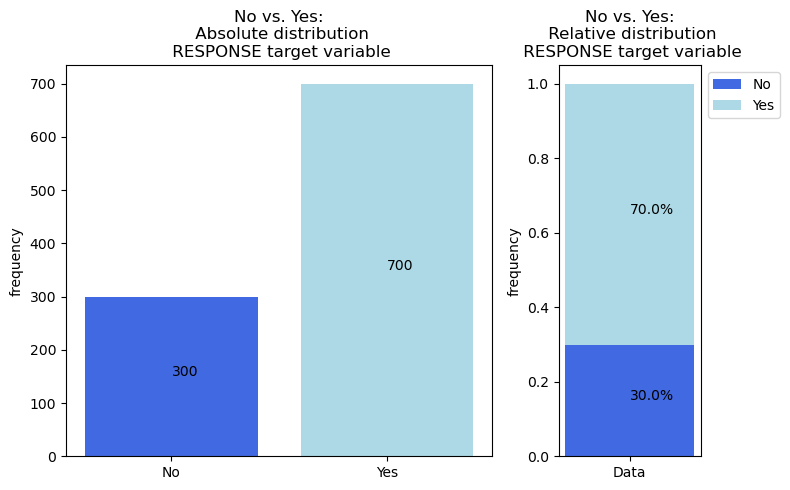

In [4]:

keys, counts = np.unique(data.RESPONSE, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) #specify relative size of left and right plot

# Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No', 'Yes'], counts, color=['royalblue','lightblue']) #left bar plot
ax0 = plt.title('No vs. Yes:\n Absolute distribution\n RESPONSE target variable') 
ax0 = plt.ylabel('frequency')
ax0 = plt.text(['No'], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(['Yes'], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

# Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='No', color = "royalblue")
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='Yes', color = "lightblue")
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('No vs. Yes:\n Relative distribution\n RESPONSE target variable')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

## Data preprocessing

Before training the models:
- The response variable is separated from feature variables
- Non-relevant columns are removed

In [5]:
FM = data.iloc[:, 1:-1]  # Selecting all features except the first and last column
TV = data.iloc[:, -1]  # Selecting the target variable

## Data split

Data is split into training (70%) and test (30%) sets

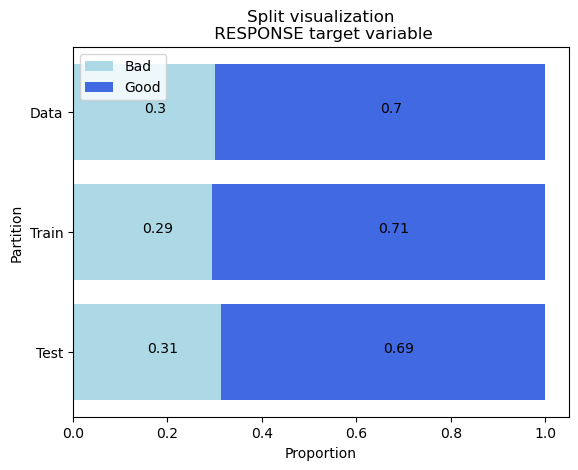

In [6]:
X_train, X_test, y_train, y_test = train_test_split(FM, TV, test_size=0.3, random_state=1234)
#normalize absolute count values for plotting
train_dist = y_train.value_counts() / len(y_train)
test_dist = y_test.value_counts() / len(y_test)
data_dist = data['RESPONSE'].value_counts() / len(data)
fig, ax = plt.subplots()
ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='lightblue', label='Bad')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='royalblue', label='Good')
ax.set_title('Split visualization\n RESPONSE target variable')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## Build an (unbalanced) Decision Tree model

A Decision Tree classifier is built on the original unbalanced dataset using:
- DecisionTreeClassifier() with parameters:
  - criterion='gini'
  - max_depth=3
  - min_samples_leaf=3

Accuracy of the model is calculated using accuracy_score()

In [7]:
clf = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=3)
clf.fit(X_train, y_train) 
DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=100)
y_pred = clf.predict(X_test)
y_pred_probs = clf.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test,y_pred)*100).round(2))

Accuracy is:  69.67


## Rebalancing with SMOTE

To address the imbalance in the dataset:
- SMOTE is applied to generate synthetic minority class samples
- A new Decision Tree model is trained on the balanced dataset
- Accuracy of the SMOTE-based model is evaluated

In [8]:
sm = SMOTE(random_state=42, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(X_train, y_train)


### Build a balanced Decision Tree model

In [9]:
clf_2 = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=3)
clf_2.fit(X_res, y_res) 
DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=100)
y_pred_1 = clf_2.predict(X_test)
y_pred_probs_1 = clf_2.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_1)*100).round(2))

Accuracy is:  63.67


## Model evaluation


### 1.Confusion Matrix

Confusion matrices are plotted for both models (with and without SMOTE) to assess performance:
- True Positives (TP), False Positives (FP)
- True Negatives (TN), False Negatives (FN)

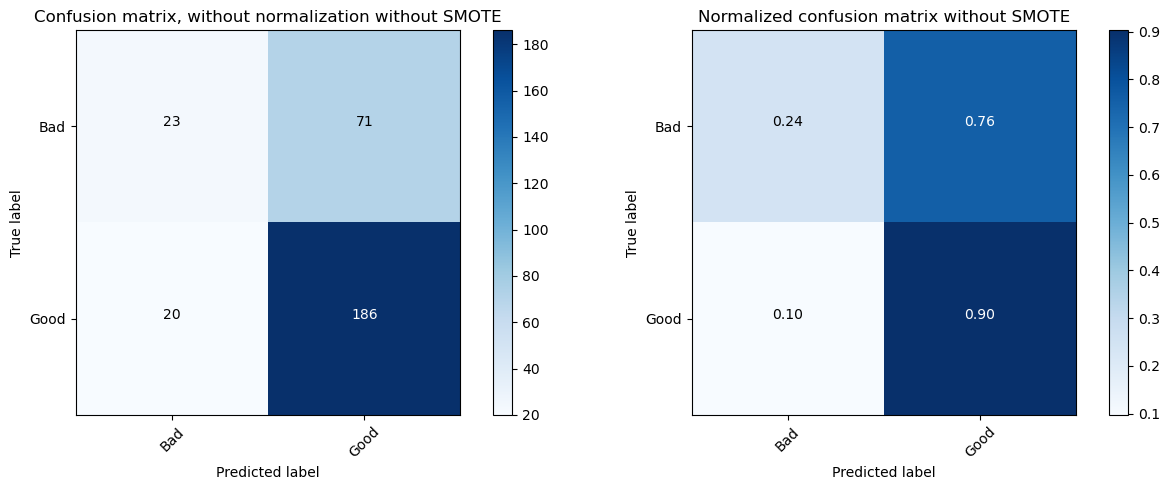

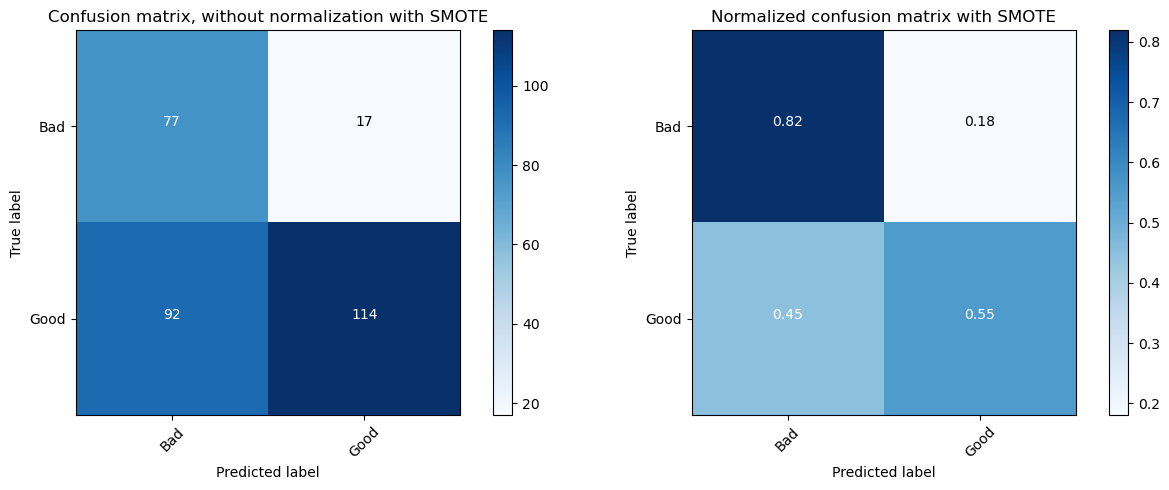

In [10]:
# WITHOUT SMOTE

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
class_names = ['Bad', 'Good']
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization without SMOTE')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix without SMOTE')


plt.show()

#WITH SMOTE

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
class_names = ['Bad', 'Good']
cnf_matrix = confusion_matrix(y_test, y_pred_1)
np.set_printoptions(precision=2)

plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization with SMOTE')

plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix with SMOTE')


plt.show()

### 2.ROC and AUC

The ROC curve and AUC score are computed for both models:
- roc_curve() generates False Positive Rate (FPR) and True Positive Rate (TPR)
- auc() computes the Area Under the Curve (AUC)
- Higher AUC values indicate better classification performance

AUC score on Testing: 0.7089960751910762
AUC score on Testing: 0.6867382772154516


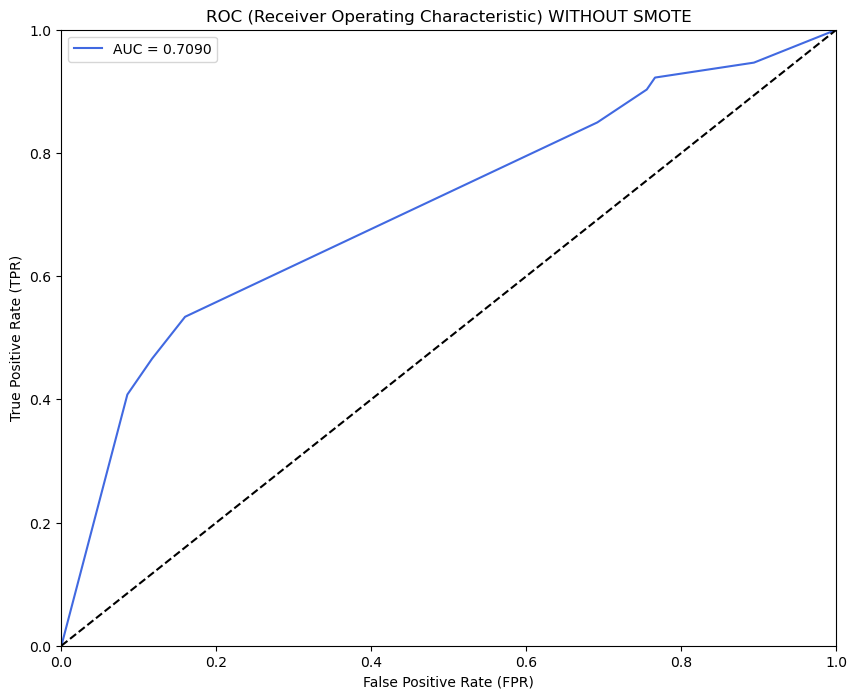

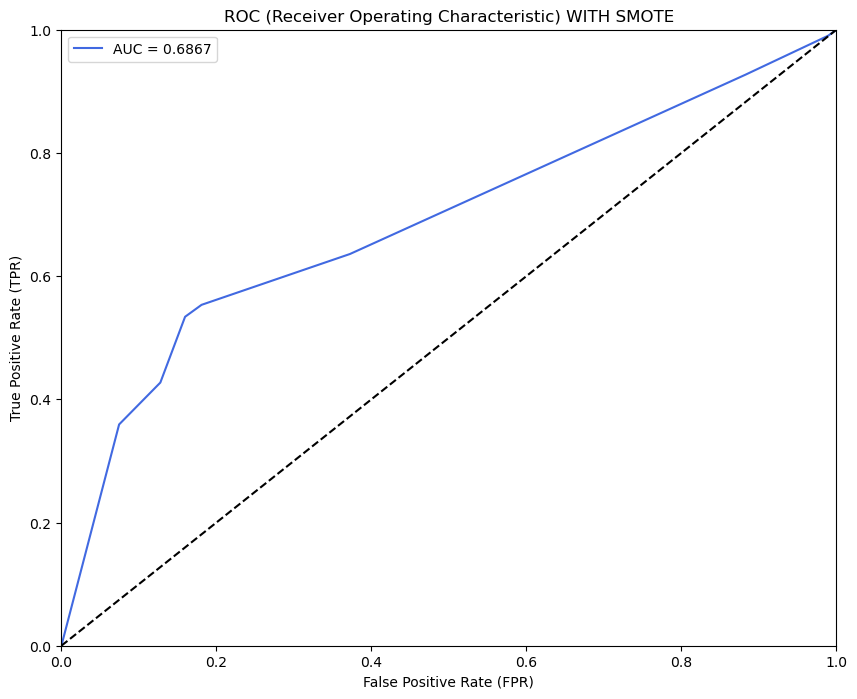

In [11]:
#AUC WITHOUT SMOTE
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_probs[:,1])
roc_auc_1 = auc(fpr_1, tpr_1)
print("AUC score on Testing: " + str(roc_auc_1))

#AUC WITH SMOTE
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_probs_1[:,1])
roc_auc_2 = auc(fpr_2, tpr_2)
print("AUC score on Testing: " + str(roc_auc_2))

#ROC WITHOUT SMOTE
fig, axs = plt.subplots(1,1, figsize=(10,8))
plt.title('ROC (Receiver Operating Characteristic) WITHOUT SMOTE')
plt.plot(fpr_1, tpr_1, 'royalblue', label='AUC = %0.4f'% roc_auc_1)
plt.legend(loc='best')
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)');

#ROC WITH SMOTE
fig, axs = plt.subplots(1,1, figsize=(10,8))
plt.title('ROC (Receiver Operating Characteristic) WITH SMOTE')
plt.plot(fpr_2, tpr_2, 'royalblue', label='AUC = %0.4f'% roc_auc_2)
plt.legend(loc='best')
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)');



## Results

Based on confusion matrix, ROC, and AUC, both models perform quite similarly. Therefore, there is no clear outperformer model.

Using MS Excel, I calculated expected values for both models with test set priors:

Without SMOTE: 5.67 € (per customer)
With SMOTE: 47.67 € (per customer)

This is creates a much larger gap between the performance of these two models. Hence, the misclassification costs do changes
our preferred model to the one with SMOTE.

## CONCLUSION

Both models perform similarly in accuracy, ROC and AUC. In their confusion matrices, model without SMOTE has a lot of false
positives, and model with SMOTE has only a small amount of false positives. Taking into account misclassification costs, these
false negatives are the most expensive. Therefore after calculating expected values for these two similarly performing models,
the 8.4 times greated expected value resolves my choise of model to deploy to be the model with Smote.